# W207 Group Project/Final
## Kaggle Competition: Random Acts of Pizza

Members:<br>
Daniel Elkin<br>
Mark Gin

Project Prompt:<br>
People post pizza requests on Reddit<br>
Build 2-class classifier<br>
Classify whether post will get pizza<br>
Practice mining features from text<br>

Reference links:
 - https://www.kaggle.com/c/random-acts-of-pizza
 - http://cs.stanford.edu/~althoff/raop-dataset/

Data Set:<br>
This training dataset contains a collection of 5671 textual requests for pizza from the Reddit community "Random Acts of Pizza" together with their outcome (successful/unsuccessful) and meta-data.

We will split the dataset into:
 - 25% for development
 - 75% for training

A separate dataset file was provided for testing purposes, of which we do not have the labels as to whether or not a pizza was received.

In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

/Users/Bobo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Bobo/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# import the data
df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')

# drop the target column from the data and use it for the labels
classification_column_name = 'requester_received_pizza'

train_data = df_train.drop([classification_column_name], axis=1)
train_labels = df_train[classification_column_name]

# use twenty-five percent of the training data for a dev data set
# note that we cannot use the test data set here, because we are not given their labels
train_data, dev_data, train_labels, dev_labels = train_test_split(train_data, train_labels, random_state=42)

# global dictionary of accuracies so we can plot our progress
accuracy_dict = {}
# keeping a list of model modification names, so we can plot them in a particular order
modification = {}

As we will be parsing the message body of each pizza request to utilize as features for our models, we will create term-frequency matricies of the text to use in our models as features.

In [3]:
# debug function used to print the vocabularies into a text file
def output_file(output_name, output_list):
    with open(output_name, 'w') as output:
        for i in output_list:
            output.write(i.encode('UTF-8') + "\n")

def decimal_to_percent(decimal):
    return round(decimal * 100, 2)

def basic_vectorizer():
    ''' Construct term-frequency matrices for use in models '''
    
    # use title and text of the post
    text_column = 'request_text'
    train_text = train_data['request_title'] + train_data[text_column]
    dev_text = dev_data['request_title'] + dev_data[text_column]
#    train_text = train_data[text_column]
#    dev_text = dev_data[text_column]

    # construct the term-frequency count matrix
    tf_vect = CountVectorizer()
    tf_train = tf_vect.fit_transform(train_text)
    tf_dev = tf_vect.transform(dev_text)
    
    #output_file("basic_vocab.txt", tf_vect.get_feature_names())
    
    return (tf_train, tf_dev)

(tf_train, tf_dev) = basic_vectorizer()

Next we will train basic models, without tuning, for each candidate learning model:
- Logistic Regression
- Naive Bayes
- Decision Tree
  
We will train and find the accuracies of each model.  This will give us a general idea of which learning models may be most successful and can build upon them from there.

In [4]:
def train_and_evaluate_model(model, tf_train, train_labels, tf_dev, dev_labels):
    ''' Train and score a model'''
    clf = model
    clf.fit(tf_train, train_labels)
    
    # return the accuracy and F1 scores
    accuracy = clf.score(tf_dev, dev_labels) 
    predicted = clf.predict(tf_dev)
    f1_score = metrics.f1_score(predicted, dev_labels, average=None)

    return accuracy, f1_score

def print_model_scores(model_type, accuracy, f1_score):
    ''' Print the accuracy and f1 scores '''
    
    print 'The accuracy of {} model is {}%'.format(model_type, decimal_to_percent(accuracy))
    print 'The F1 scores are: False: {}\n                    True: {}'.format(*[decimal_to_percent(score) for score in f1_score])

In [5]:
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
basic_lr = LogisticRegression()
basic_nb = BernoulliNB()
basic_dt = DecisionTreeClassifier()

modification.update({0: 'Basic'})
accuracy_dict['Basic'] = {}
for model, model_name in [(basic_lr, 'Logistic Regression'), (basic_nb, 'Naive Bayes'),
                  (basic_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_train, train_labels, tf_dev, dev_labels)
    # first time adding accuracies to dictionary
    accuracy_dict['Basic'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)


The accuracy of Logistic Regression model is 69.21%
The F1 scores are: False: 80.48
                    True: 27.17
The accuracy of Naive Bayes model is 71.98%
The F1 scores are: False: 82.8
                    True: 24.53
The accuracy of Decision Tree model is 65.74%
The F1 scores are: False: 77.59
                    True: 27.31


### Vocabulary Preprocessing
Let's attempt to build upon our basic models by introducing preprocessing algorithms for our word vocabulary vectorizer.

In [6]:
def vectorize_with_preprocessor(preprocessor_func, ngram=(1,1), mindf=1):
    ''' Construct term-frequency matrices for use in models '''
    
    # use title and text of the post
    text_column = 'request_text'
    train_text = train_data['request_title'] + train_data[text_column]
    dev_text = dev_data['request_title'] + dev_data[text_column]

    # construct the term-frequency count matrix
    tf_vect = CountVectorizer(preprocessor=preprocessor_func,
                              ngram_range=ngram,
                              min_df=mindf)
    tf = tf_vect.fit(train_text)
    
    # make the matrices global variables for convenience?
    tf_train_pp = tf.transform(train_text)
    tf_dev_pp = tf.transform(dev_text)
    
    #output_file("porter.txt", tf_vect.get_feature_names())
    #output_file("composite.txt", tf_vect.get_feature_names())
    
    return (tf_train_pp, tf_dev_pp)


In [7]:
# use porter-stemming algorithm to generalize words in the messages
# https://tartarus.org/martin/PorterStemmer/def.txt
def porter_stemming(s):
    # create a new empty string, since s is the entire message not a single word
    new_s = ""
    
    # iterate through each word in space delimited string
    for w in s.split():
        # calculate the measure, which is the number of vowel to consanant transitions
        m_cnt = 0
        if (re.search('^[^aeiou]*(([aeiou]+[^aeiou]+)+)[aeiou]*$', w)):
            measure_match = re.match('^[^aeiou]*(([aeiou]+[^aeiou]+)+)[aeiou]*$', w)
            # split on vowels to count number of transitions
            consanant_groups = re.split('[aeiou]+', measure_match.group(1))
            m_cnt = len(consanant_groups) - 1
        
        # Step 1a of porter stemming
        if re.search('sses$', w):
            w = re.sub('sses$', 'ss', w)
        elif re.search('ies$', w):
            w = re.sub('ies$', 'i', w)
        elif re.search('ss$', w):
            w = re.sub('ss$', 'i', w)
        elif re.search('s$', w):
            w = re.sub('s$', '', w)
        # Step 1b
        # Porter-Stemming says this should be m_cnt > 0, but doesn't
        # even match their own examples, tweaked to 1 and got slightly better performance
#        if (m_cnt > 1 and re.search('eed$', w)):
#            w = re.sub('eed$', 'ee', w)
#        elif (re.search('.*[aeiou].*(ed|ing)$', w)):
#            w = re.sub('(ed|ing)$', '', w)
#            # if the second or third rule of 1b is successful, we also
#            if (re.search('(at|bl|iz)$', w)):
#                w += 'e'
#            # ends in double consanant, but no l s or z
#            elif (re.search('.*([^aeiou])([^aeiou])$', w)) :
#                m = re.match('(.*)([^aeiou])([^aeiou])$', w)
#                if (m.group(3) == m.group(2) and
#                    m.group(3) != 'l' and
#                    m.group(3) != 's' and
#                    m.group(3) != 'z') :
#                    w = m.group(1) + m.group(2)
#            # measure at least one and ends in cvc
#            # but second c is not W,X,Y
#            elif (m_cnt == 1 and re.search('^.*[^aeiou][aeiou][^aeiouwxy]$', w)) :
#                w = re.sub('[^aeiouwxy]$', 'e', w)
        # Step 1c
        if (re.search('.*[aeiou].*y$', w)) :
            w = re.sub('y$', 'i', w)
        # Step 2
        if (m_cnt > 0) :
            if (re.search('ational$', w)) :
                w = re.sub('ational$', 'ate', w)
            elif (re.search('tional$', w)) :
                w = re.sub('tional$', 'tion', w)
            elif (re.search('enci$', w)) :
                w = re.sub('enci$', 'ence', w)
            elif (re.search('anci$', w)) :
                w = re.sub('anci$', 'ance', w)
            elif (re.search('izer$', w)) :
                w = re.sub('izer$', 'ize', w)
            elif (re.search('abli$', w)) :
                w = re.sub('abli$', 'able', w)
            elif (re.search('alli$', w)) :
                w = re.sub('alli$', 'al', w)
            elif (re.search('entli$', w)) :
                w = re.sub('entli$', 'ent', w)
            elif (re.search('eli$', w)) :
                w = re.sub('eli$', 'e', w)
            elif (re.search('ousli$', w)) :
                w = re.sub('ousli$', 'ous', w)
            elif (re.search('ization$', w)) :
                w = re.sub('ization$', 'ize', w)
            elif (re.search('(ation|ator)$', w)) :
                w = re.sub('(ation|ator)$', 'ate', w)
            elif (re.search('alism$', w)) :
                w = re.sub('alism$', 'al', w)
            elif (re.search('iveness$', w)) :
                w = re.sub('iveness$', 'ive', w)
            elif (re.search('fulness$', w)) :
                w = re.sub('fulness$', 'ful', w)
            elif (re.search('ousness$', w)) :
                w = re.sub('ousness$', 'ous', w)
            elif (re.search('aliti$', w)) :
                w = re.sub('aliti$', 'al', w)
            elif (re.search('iviti$', w)) :
                w = re.sub('iviti$', 'ive', w)
            elif (re.search('biliti$', w)) :
                w = re.sub('biliti$', 'ble', w)
        # Step 3
        if (m_cnt > 0) :
            if (re.search('icate$', w)) :
                w = re.sub('icate$', 'ic', w)
            elif (re.search('ative$', w)) :
                w = re.sub('ative$', '', w)
            elif (re.search('alize$', w)) :
                w = re.sub('alize$', 'al', w)
            elif (re.search('iciti$', w)) :
                w = re.sub('iciti$', 'ic', w)
            elif (re.search('ical$', w)) :
                w = re.sub('ical$', 'ic', w)
            elif (re.search('ful$', w)) :
                w = re.sub('ful$', '', w)
            elif (re.search('ness$', w)) :
                w = re.sub('ness$', '', w)
        # Step 4
        if (m_cnt > 1) :
            if (re.search('al$', w)) :
                w = re.sub('al$', '', w)
            elif (re.search('ance$', w)) :
                w = re.sub('ance$', '', w)
            elif (re.search('ence$', w)) :
                w = re.sub('ence$', '', w)
            elif (re.search('er$', w)) :
                w = re.sub('er$', '', w)
            elif (re.search('ic$', w)) :
                w = re.sub('ic$', '', w)
            elif (re.search('able$', w)) :
                w = re.sub('able$', '', w)
            elif (re.search('ible$', w)) :
                w = re.sub('ible$', '', w)
            elif (re.search('ant$', w)) :
                w = re.sub('ant$', '', w)
            elif (re.search('ement$', w)) :
                w = re.sub('ement$', '', w)
            elif (re.search('ent$', w)) :
                w = re.sub('ent$', '', w)
            elif (m_cnt > 1 and re.search('[s|t]ion$', w)) :
                w = re.sub('[s|t]ion$', '', w)
            elif (re.search('ou$', w)) :
                w = re.sub('ou$', '', w)
            elif (re.search('ism$', w)) :
                w = re.sub('ism$', '', w)
            elif (re.search('ate$', w)) :
                w = re.sub('ate$', '', w)
            elif (re.search('iti$', w)) :
                w = re.sub('iti$', '', w)
            elif (re.search('ous$', w)) :
                w = re.sub('ous$', '', w)
            elif (re.search('ive$', w)) :
                w = re.sub('ive$', '', w)
            elif (re.search('ize$', w)) :
                w = re.sub('ize$', '', w)
        # Step 5a
        if (m_cnt > 1 and re.search('e$', w)) :
            w = re.sub('e$', '', w)
        # measure at least one and ends in cvc
        # but second c is not W,X,Y
        elif (m_cnt == 1 and not re.search('^[^aeiou][aeiou][^aeiouwxy]e$', w)) :
            w = re.sub('e$', '', w)
        # Step 5b
        if (m_cnt > 1 and re.search('.*ll$', w)):
            w = re.sub('l$', '', w)
        # end of porter stemming
        # attach the word back to the new string
        new_s += (" " + w)
    return new_s

In [8]:
def stopword_preprocessor(s):    
    # remove "stop" words which bear no significant meaning in most contexts
    s = re.sub(' ?the ', r' ', s)
    s = re.sub(' ?who ', r' ', s)
    s = re.sub(' ?what ', r' ', s)
    s = re.sub(' ?them ', r' ', s)
    s = re.sub(' ?my ', r' ', s)
    s = re.sub(' ?our ', r' ', s)
    s = re.sub(' ?this ', r' ', s)
    s = re.sub(' ?that ', r' ', s)
    s = re.sub(' ?which ', r' ', s)
    s = re.sub(' ?why ', r' ', s)
    s = re.sub(' ?me ', r' ', s)
    #s = re.sub(' ?i ', r' ', s)
    #s = re.sub(' ?us ', r' ', s)
    #s = re.sub(' ?you ', r' ', s)
    s = re.sub(' ?they ', r' ', s)
    s = re.sub(' ?where ', r' ', s)
    s = re.sub(' ?and ', r' ', s)
    s = re.sub(' ?for ', r' ', s)
    s = re.sub(' ?his ', r' ', s)
    s = re.sub(' ?her ', r' ', s)
    s = re.sub(' ?to ', r' ', s)
    #s = re.sub(' ?of ', r' ', s)
    
    # let's also get rid of 'request' and 'pizza' since they show up frequently in titles
    s = re.sub('request', r'', s)
    s = re.sub('pizza', r'', s)
    
    return s

In [9]:
# Basic string preprocessor:
# lowercases all text, removes, digits and special characters
def basic_preprocessor(s):
    # make everything lowercase
    s = s.lower()
    
    # eliminate consecutive digits
    s = re.sub('([0-9])[0-9]+', r'\1', s)
    
    # eliminate all digits
    #s = re.sub('[0-9]+', r'', s)
    
    # eliminate special characters, except hyphens
    s = re.sub('[^A-Za-z0-9\s\-]+', ' ', s)
    
    # add a space between consecutive numbers/alpha
    s = re.sub('([0-9])([a-z])', '\1 \2', s)
    s = re.sub('([a-z])([0-9])', '\1 \2', s)
    
    return s

In [10]:
# uses the other preprocessors already written above
# to form a composite preprocessor
def composite_preprocessor(s):
    s = basic_preprocessor(s)
    s = stopword_preprocessor(s)
    #s = porter_stemming(s)
    
    return s

We developed different preprocessors with different functionalities:
- Basic Preprocessor
 - Lower case text, removes consecutive digits
- Stopword Preprocessor
 - Removes common, non contextual stopwords (the, that, and... etc)
- Porter-Stemming Preprocessor
 - Advanced preprocessing of vocabulary, suffix removal
 - Example: learning -> learn

We retrained new basic models, this time we use an updated vocabulary based on our vectorizer preprocessor.

In [11]:
(tf_pp_train, tf_pp_dev) = vectorize_with_preprocessor(composite_preprocessor)
    
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
basic_pp_cv_lr = LogisticRegression()
basic_pp_cv_nb = BernoulliNB()
basic_pp_cv_dt = DecisionTreeClassifier()

modification.update({1:'PP Vocab'})
accuracy_dict['PP Vocab'] = {}
for model, model_name in [(basic_pp_cv_lr, 'Logistic Regression'), (basic_pp_cv_nb, 'Naive Bayes'),
                  (basic_pp_cv_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_pp_train, train_labels,
                                                  tf_pp_dev, dev_labels)
    accuracy_dict['PP Vocab'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)


The accuracy of Logistic Regression model is 70.1%
The F1 scores are: False: 81.24
                    True: 26.34
The accuracy of Naive Bayes model is 71.88%
The F1 scores are: False: 82.81
                    True: 22.83
The accuracy of Decision Tree model is 65.64%
The F1 scores are: False: 77.74
                    True: 24.73


In our testing, we found the best results by compositing our basic preprocessor with the stopword preprocessor.  The Porter-Stemming preprocessor seemed to actually have an adverse impact in accuracy, albeit, marginal.

Using the composite preprocessor (basic and stopword), the accuracy of for our models changed:
- Logistic Regression model from 69.21% to 70.1%
- Naive Bayes model from 71.98% to 71.88%
- Decision Tree model from 67.72% to 64.75%

Although the addition of preprocessing had only marginal impacts to Logistic Regression and Naive Bayes, in our dataset, it appears to have improved Logistic Regression, if only slightly and had a negative affect for Naive Bayes, also only slightly.  Decision Tree modeling was more adversely affected by the introduction of preprocessing.

Overall, Naive Bayes appears to be performing better than the Logistic Regression and Decision Tree models, although only about 2% better over the Logistic Regression model.

In [12]:
# Vectorize textual data with TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(preprocessor_func, ngram=(1,1)):
    # use title and text of the post
    text_column = 'request_text'
    train_text = train_data['request_title'] + train_data[text_column]
    dev_text = dev_data['request_title'] + dev_data[text_column]

    # construct the term-frequency count matrix
    tfidf_vect = TfidfVectorizer(preprocessor=preprocessor_func, ngram_range=ngram)
    tfidf = tfidf_vect.fit(train_text)
    
    tfidf_train = tfidf_vect.transform(train_text)
    tfidf_dev = tfidf_vect.transform(dev_text)
    
    return (tfidf_train, tfidf_dev)

(tfidf_pp_train, tfidf_pp_dev) = tfidf_vectorizer(composite_preprocessor)

basic_pp_tfidf_lr = LogisticRegression()
basic_pp_tfidf_nb = BernoulliNB()
basic_pp_tfidf_dt = DecisionTreeClassifier()

modification.update({2: 'TF-IDF Vocab'})
accuracy_dict['TF-IDF Vocab'] = {}
for model, model_name in [(basic_pp_tfidf_lr, 'Logistic Regression'),
                          (basic_pp_tfidf_nb, 'Naive Bayes'),
                          (basic_pp_tfidf_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model,
                                                  tfidf_pp_train, train_labels,
                                                  tfidf_pp_dev, dev_labels)
    accuracy_dict['TF-IDF Vocab'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)

The accuracy of Logistic Regression model is 74.85%
The F1 scores are: False: 85.45
                    True: 7.3
The accuracy of Naive Bayes model is 71.88%
The F1 scores are: False: 82.81
                    True: 22.83
The accuracy of Decision Tree model is 62.77%
The F1 scores are: False: 75.17
                    True: 25.69


We attempted to also try a TF-IDF (Term Frequncy) vectorizer for our training vocabulary to see if using a different vectorizer method would bear significant improvment to our models.  We found a good improvment in overall accuracy of our Logistic Regression model but did not find any signifcant differences in applying a different vectorizer to Naive Bayes whereas  Decision Tree model was adversely affected:
 - Logistic Regression 70.1 to 74.85
 - Naive Bayes 71.88 to 71.88
 - Decision Tree 64.75 to 62.57

An additional potential improvment to both models is to modify our count vectorizer to include bi-gram text, as opposed to uni-gram text which is currently being used.

In [13]:
print "Using Count Vectorizer and bi-gram vocabulary:"
bi_gram = (1,2)
(tf_bi_train, tf_bi_dev) = vectorize_with_preprocessor(composite_preprocessor, bi_gram)
    
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
basic_bi_lr = LogisticRegression()
basic_bi_nb = BernoulliNB()
basic_bi_dt = DecisionTreeClassifier()

modification.update({3: 'CV Bi-gram'})
accuracy_dict['CV Bi-gram'] = {}
for model, model_name in [(basic_bi_lr, 'Logistic Regression'), (basic_bi_nb, 'Naive Bayes'),
                  (basic_bi_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_bi_train, train_labels,
                                                  tf_bi_dev, dev_labels)
    accuracy_dict['CV Bi-gram'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)
    
print "Using TF-IDF Vectorizer and bi-gram vocabulary:"
(tfidf_bi_train, tfidf_bi_dev) = tfidf_vectorizer(composite_preprocessor, bi_gram)

basic_tfidf_bi_lr = LogisticRegression()
basic_tfidf_bi_nb = BernoulliNB()
basic_tfidf_bi_dt = DecisionTreeClassifier()

modification.update({4: 'TF-IDF Bi-gram'})
accuracy_dict['TF-IDF Bi-gram'] = {}
for model, model_name in [(basic_tfidf_bi_lr, 'Logistic Regression'),
                          (basic_tfidf_bi_nb, 'Naive Bayes'),
                          (basic_tfidf_bi_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model,
                                                  tfidf_bi_train, train_labels,
                                                  tfidf_bi_dev, dev_labels)
    accuracy_dict['TF-IDF Bi-gram'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)


Using Count Vectorizer and bi-gram vocabulary:
The accuracy of Logistic Regression model is 70.59%
The F1 scores are: False: 82.03
                    True: 19.07
The accuracy of Naive Bayes model is 73.96%
The F1 scores are: False: 85.0
                    True: 1.5
The accuracy of Decision Tree model is 68.71%
The F1 scores are: False: 80.15
                    True: 26.17
Using TF-IDF Vectorizer and bi-gram vocabulary:
The accuracy of Logistic Regression model is 74.46%
The F1 scores are: False: 85.34
                    True: 0.77
The accuracy of Naive Bayes model is 73.96%
The F1 scores are: False: 85.0
                    True: 1.5
The accuracy of Decision Tree model is 62.57%
The F1 scores are: False: 74.7
                    True: 28.14


The bi-gram vocabularies, using both the Count and TF-IDF vectorizers had mixed results, with marginal improvments and degredation in overall accuracy for various models.  It should also be noted that when there was improvment, the F1 score for sucessful pizza requests dropped significantly, which means our models are likely over-fitting/over-predicting the false class which is proportinately larger.

### Tuning Model Hyperparameters
We will attempt to tune a basic model with preprocessed vocabulary by gridsearching over various hyperparameters.

In [14]:
# generic grid search which can field different models and hyperparameters
# and output the best results
def gridsearch_model(model, parameters, tf_dev, dev_labels): 
    gridsearch = GridSearchCV(estimator=model,
                              param_grid=parameters)
    gridsearch.fit(tf_dev, dev_labels)
    
    print "Best parameters:"
    print gridsearch.best_params_
    return gridsearch
    
# c_values for logistic regression
c_values = {'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                  5.0, 10.0, 15.0, 20.0, 25.0, 50.0, 75.0, 100.0]}

# logistic regression tuning using the preprocessed vocabulary model
lr_gs = gridsearch_model(basic_pp_cv_lr, c_values, tf_pp_dev, dev_labels)

# use optimal parameters
tuned_lr = LogisticRegression(C=lr_gs.best_params_['C'])
tuned_lr.fit(tf_pp_train, train_labels)
lr_accuracy = tuned_lr.score(tf_pp_dev, dev_labels) 
lr_predicted = tuned_lr.predict(tf_pp_dev)
lr_f1_score = metrics.f1_score(lr_predicted, dev_labels, average=None)
print_model_scores("Tuned Logistic Regression with CV", lr_accuracy, lr_f1_score)

# grid search again, this time using our preprocessed TF-IDF vocabulary
lr_gs = gridsearch_model(basic_pp_tfidf_lr, c_values, tfidf_pp_dev, dev_labels)

# use optimal parameters
tuned_tfidf_lr = LogisticRegression(C=lr_gs.best_params_['C'])
tuned_tfidf_lr.fit(tfidf_pp_train, train_labels)
lr_tfidf_accuracy = tuned_tfidf_lr.score(tfidf_pp_dev, dev_labels) 
lr_tfidf_predicted = tuned_tfidf_lr.predict(tfidf_pp_dev)
lr_tfidf_f1_score = metrics.f1_score(lr_tfidf_predicted, dev_labels, average=None)
print_model_scores("Tuned Logistic Regression with TF-IDF", lr_tfidf_accuracy, lr_tfidf_f1_score)

# manual tuning parameters with preprocessed CV
manual_lr = LogisticRegression(C=0.15)
manual_lr.fit(tf_pp_train, train_labels)
manual_lr_accuracy = manual_lr.score(tf_pp_dev, dev_labels) 
manual_lr_predicted = manual_lr.predict(tf_pp_dev)
manual_lr_f1_score = metrics.f1_score(manual_lr_predicted, dev_labels, average=None)
print_model_scores("Manual Tuned Logistic Regression with CV", manual_lr_accuracy, manual_lr_f1_score)

# manual tuning parameters with preprocessed TF-IDF
manual_tfidf_lr = LogisticRegression(C=5)
manual_tfidf_lr.fit(tfidf_pp_train, train_labels)
manual_lr_tfidf_accuracy = manual_tfidf_lr.score(tfidf_pp_dev, dev_labels) 
manual_lr_tfidf_predicted = manual_tfidf_lr.predict(tfidf_pp_dev)
manual_lr_tfidf_f1_score = metrics.f1_score(manual_lr_tfidf_predicted, dev_labels, average=None)
print_model_scores("Manual Tuned Logistic Regression with TF-IDF", manual_lr_tfidf_accuracy, manual_lr_tfidf_f1_score)

Best parameters:
{'C': 0.001}
The accuracy of Tuned Logistic Regression with CV model is 74.55%
The F1 scores are: False: 85.42
                    True: 0.0


/Users/Bobo/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best parameters:
{'C': 0.001}
The accuracy of Tuned Logistic Regression with TF-IDF model is 74.55%
The F1 scores are: False: 85.42
                    True: 0.0
The accuracy of Manual Tuned Logistic Regression with CV model is 71.88%
The F1 scores are: False: 82.95
                    True: 19.77
The accuracy of Manual Tuned Logistic Regression with TF-IDF model is 72.38%
The F1 scores are: False: 83.38
                    True: 18.18


In [15]:
# naive bayes tuning
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0,]}
gridsearch_model(basic_pp_cv_nb, params, tf_pp_dev, dev_labels)

tuned_nb = BernoulliNB(alpha=0.85)
tuned_nb.fit(tf_pp_train, train_labels)
nb_accuracy = tuned_nb.score(tf_pp_dev, dev_labels)
nb_predicted = tuned_nb.predict(tf_pp_dev)
nb_f1_score = metrics.f1_score(nb_predicted, dev_labels, average=None)
print_model_scores("Tuned Naive Bayes with CV", nb_accuracy, nb_f1_score)

# TF-IDF vocabulary w/ Naive Bayes tuning
gridsearch_model(basic_pp_tfidf_nb, params, tf_pp_dev, dev_labels)
# use optimal parameters
tuned_tfidf_nb = BernoulliNB(alpha=0.85)
tuned_tfidf_nb.fit(tfidf_pp_train, train_labels)
nb_tfidf_accuracy = tuned_tfidf_nb.score(tfidf_pp_dev, dev_labels) 
nb_tfidf_predicted = tuned_tfidf_lr.predict(tfidf_pp_dev)
nb_tfidf_f1_score = metrics.f1_score(nb_tfidf_predicted, dev_labels, average=None)
print_model_scores("Tuned Naive Bayes with TF-IDF", nb_tfidf_accuracy, nb_tfidf_f1_score)

# manual tuning parameters with preprocessed CV
manual_nb = LogisticRegression(C=0.1)
manual_nb.fit(tf_pp_train, train_labels)
manual_nb_accuracy = manual_nb.score(tf_pp_dev, dev_labels) 
manual_nb_predicted = manual_nb.predict(tf_pp_dev)
manual_nb_f1_score = metrics.f1_score(manual_nb_predicted, dev_labels, average=None)
print_model_scores("Manual Tuned Naive Bayes with CV", manual_nb_accuracy, manual_nb_f1_score)

# manual tuning parameters with preprocessed TF-IDF
manual_tfidf_nb = LogisticRegression(C=5)
manual_tfidf_nb.fit(tfidf_pp_train, train_labels)
manual_nb_tfidf_accuracy = manual_tfidf_nb.score(tfidf_pp_dev, dev_labels) 
manual_nb_tfidf_predicted = manual_tfidf_nb.predict(tfidf_pp_dev)
manual_nb_tfidf_f1_score = metrics.f1_score(manual_nb_tfidf_predicted, dev_labels, average=None)
print_model_scores("Manual Tuned Naive Bayes with TF-IDF", manual_nb_tfidf_accuracy, manual_nb_tfidf_f1_score)

Best parameters:
{'alpha': 0.95}
The accuracy of Tuned Naive Bayes with CV model is 71.58%
The F1 scores are: False: 82.49
                    True: 24.67
Best parameters:
{'alpha': 0.95}
The accuracy of Tuned Naive Bayes with TF-IDF model is 71.58%
The F1 scores are: False: 85.42
                    True: 0.0
The accuracy of Manual Tuned Naive Bayes with CV model is 72.67%
The F1 scores are: False: 83.59
                    True: 18.34
The accuracy of Manual Tuned Naive Bayes with TF-IDF model is 72.38%
The F1 scores are: False: 83.38
                    True: 18.18


Interestingly, while using grid search we were able to optimize hyperparameter values, C and alpha, for Logistic Regression and Naive Bayes, respectively, that improved overall accuracy of the models.  However, using these optimize values provided very low F1 scores and low accuracy for our two categories of prediction (True = Pizza Received/False = Pizza Not Received).  What this means, is that our gridsearch tuned models are simply predicting everything to be false in order to optimize overall accuracy.

Trial and error proved to be more effective in improving overall accuracy without completely sacrificing our F1 scores for our categories.

From this information, it is possible there is a class imbalance in our training data and the model is merely always guessing False/unsuccessful pizza requests to obtain a higher accuracy.  If there is a class imbalance in our training data, it may be difficult for the model to distinguish between sucessful and unsucessful features.

### Class Imbalance/Weighting
Based on the information we learned while attempting to tune our models, we will investigate and attempt to account for a class imbalance in our training dataset.

In [16]:
# doing some exploration to find out if there is a class imbalance in our training data
# by counting the outcome classes in our training set
def class_counts():
    counts = [0, 0]
    for i in train_labels:
        counts[i] += 1
    
    for i in range(len(counts)):
        print i, counts[i]
        
class_counts()

0 2293
1 737


We observe from our class counting that there is indeed some weight imbalance in our training set.   There are far more classes in the unsucessful requests compared to the sucessful requests, roughly 3 to 1, in the favor of unsuccessful requests.  We can use this knowledge to weight our classes for training to improve prediction accuracy.

In [17]:
# There is some class imbalance, so lets try weighting based on the ratio of classes
weight_dict = {0: 0.33, 1: .67}
lr_weight = LogisticRegression(C=0.1, class_weight='balanced')
lr_weight.fit(tf_pp_train, train_labels)
lrw_accuracy = lr_weight.score(tf_pp_dev, dev_labels) 
lrw_predicted = lr_weight.predict(tf_pp_dev)
lrw_f1_score = metrics.f1_score(lrw_predicted, dev_labels, average=None)
print_model_scores("Weighed Logistic Regression", lrw_accuracy, lrw_f1_score)

The accuracy of Weighed Logistic Regression model is 65.94%
The F1 scores are: False: 76.97
                    True: 34.6


We experimented with manual weighting adjustment, but found that using the 'balanced' weighting typing showed the greatest improvement to the F1 accuracy for the "True' class, but our overall accuracy suffers significantly.

### Applying Other Features

Next we will experiment with applying other features from the dataset.  We generate a tabular output showing the updated accuracy and F1 scores for applying a single feature in addition to our vocabulary for analysis.  From this, we can continue to experiment and apply different features to improve our models.

In [18]:
import scipy as sp

num_train_examples = train_data.shape[0]
num_dev_examples = dev_data.shape[0]

# We start with the preprocessed vocabulary as a basis
# but we add a single field from the dataset
def addFeature(field, tf_train, tf_dev):
    new_train_col = train_data[field].values.reshape(num_train_examples,1)
    new_dev_col = dev_data[field].values.reshape(num_dev_examples,1)
    tf_train_plus = sp.sparse.hstack((tf_train, 
                                     new_train_col, 
                                     ), format='csr')
    tf_dev_plus = sp.sparse.hstack((tf_dev, 
                                   new_dev_col, 
                                   ), format='csr')
    return tf_train_plus, tf_dev_plus

# print the table header
print '%50.50s %20.20s %6.6s %5.5s %5.5s' %("Attribue Name", "Model", "Acc", "False", "True")

# Loop through all the different attribute fields in the dataset,
# picking one out at a time to add to the feature vector to see how a single one improves (or not)
for k in sorted(train_data.columns):
    # skip these since we already have the text features
    if (k == "request_text" or k == "request_title"):
        continue
    # these are giving the transform some compile errors, skipping them
    elif (k == "giver_username_if_known" or
          k == "request_id" or
          k == "request_text_edit_aware" or
          k == "requester_subreddits_at_request" or
          k == "requester_user_flair" or
          k == "requester_username"):
        continue
    # train basic models to gauge baseline performance of the models
    # Logisitc Regression, Naive Bayes, Decision Tree
    # calling af for added features
    basic_af_lr = LogisticRegression()
    basic_af_nb = BernoulliNB()
    basic_af_dt = DecisionTreeClassifier()

    # use this to flag if its the first model to print in the attribute
    # used for formatting the print later
    att_flag = 0
    
    tf_train_plus, tf_dev_plus = addFeature(k, tf_pp_train, tf_pp_dev)
    
    for model, model_name in [(basic_af_lr, 'Logistic Regression'), (basic_af_nb, 'Naive Bayes'),
                      (basic_af_dt, 'Decision Tree')]:
        accuracy, f1_score = train_and_evaluate_model(model, tf_train_plus, train_labels,
                                                      tf_dev_plus, dev_labels)
        #print_model_scores(model_name, accuracy, f1_score)
        
        # print a table of values
        # attribute       model     accuracy f1_false f1_true
        #                 model     accuracy f1_false f1_true
        if (att_flag == 1):
            print '%50.50s %20.20s %1.4f %1.4f %1.4f' %("", model_name, accuracy, f1_score[0], f1_score[1])
        else:
            print '%50.50s %20.20s %1.4f %1.4f %1.4f' %(k, model_name, accuracy, f1_score[0], f1_score[1]) 
            att_flag = 1

                                     Attribue Name                Model    Acc False  True
       number_of_downvotes_of_request_at_retrieval  Logistic Regression 0.7010 0.8129 0.2562
                                                            Naive Bayes 0.7178 0.8276 0.2234
                                                          Decision Tree 0.6842 0.7959 0.3020
         number_of_upvotes_of_request_at_retrieval  Logistic Regression 0.7040 0.8146 0.2654
                                                            Naive Bayes 0.7188 0.8281 0.2283
                                                          Decision Tree 0.6782 0.7907 0.3041
                                   post_was_edited  Logistic Regression 0.7455 0.8542 0.0000
                                                            Naive Bayes 0.7188 0.8281 0.2283
                                                          Decision Tree 0.6802 0.7931 0.2963
           request_number_of_comments_at_retrieval  Logistic Regression 

Some interesting findings here, the features: 'requester_number_of_comments_in_raop_at_retrieval' and 'requester_number_of_posts_on_raop_at_retrieval' seem to have a positive effect on prediction accuracy.  One possible reason is that the requester has continued to remain engaged in discussion with the community and people are more likely to help someone out who is engaged as opposed to users who request a pizza but are not heard from again, which may be interpreted by others as freeloading or begging.  Any engaged requester may be continuing to communicate their needs and are seen as part of the community.

It's also interesting to see that the 'unix_timestamp_of_request' and 'unix_timestamp_of_request_utc' also have positive influence upon accuracy.  This appears to be the Unix time in epochs.  Adding this feature does not prove to explain or add to the story of overall accuracy, except perhaps, more recent requests are more or less likely to garner a pizza as the forum has gained or waned in popularity (most likely gained) and people are feeling more or less generous in that capacity.  For now, we will not be including that feature into our models.

In [19]:
# introduce other features from the dataset to combine with text features we extracted
# from the message bodies
import scipy as sp

num_train_examples = train_data.shape[0]
num_dev_examples = dev_data.shape[0]

# We start with the preprocessed vocabulary as a basis

tf_train_plus = sp.sparse.hstack((
                    tf_pp_train, 
                    train_data['number_of_upvotes_of_request_at_retrieval'].values.reshape(num_train_examples, 1), 
                    train_data['request_number_of_comments_at_retrieval'].values.reshape(num_train_examples, 1),
                    train_data['requester_number_of_posts_on_raop_at_retrieval'].values.reshape(num_train_examples, 1),
                    #train_data['unix_timestamp_of_request'].values.reshape(num_train_examples, 1),
                ), format='csr')

tf_dev_plus = sp.sparse.hstack((
                    tf_pp_dev, 
                    dev_data['number_of_upvotes_of_request_at_retrieval'].values.reshape(num_dev_examples, 1), 
                    dev_data['request_number_of_comments_at_retrieval'].values.reshape(num_dev_examples, 1),
                    dev_data['requester_number_of_posts_on_raop_at_retrieval'].values.reshape(num_dev_examples, 1),
                    #dev_data['unix_timestamp_of_request'].values.reshape(num_dev_examples, 1),
                ), format='csr')
    
# train basic models to gauge baseline performance of the models
# Logisitc Regression
# Naive Bayes
# Decision Tree
# calling af for added features
basic_af_lr = LogisticRegression()
basic_af_nb = BernoulliNB()
basic_af_dt = DecisionTreeClassifier()

modification.update({5: 'CV Vocab w AF'})
accuracy_dict['CV Vocab w AF'] = {}
for model, model_name in [(basic_af_lr, 'Logistic Regression'), (basic_af_nb, 'Naive Bayes'),
                  (basic_af_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_train_plus, train_labels,
                                                  tf_dev_plus, dev_labels)
    accuracy_dict['CV Vocab w AF'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)

The accuracy of Logistic Regression model is 76.63%
The F1 scores are: False: 84.99
                    True: 47.32
The accuracy of Naive Bayes model is 71.98%
The F1 scores are: False: 82.88
                    True: 22.89
The accuracy of Decision Tree model is 79.5%
The F1 scores are: False: 86.41
                    True: 58.35


By introducing additional features from our dataset beyond the textual vocabulary, we were able to improve accuracy from our "basic" models.

### Vocabulary Reduction (L1 Regularization)

We next attempt to improve the performance of our Logistic Regression model by first training such a model with L1 regularization and using only the features in that model that are non-zero as the input for a model that uses L2 regularization. We are effectively removing unimportant features.

In [20]:
# fit an L1 model 
lr_with_l1 = LogisticRegression(penalty='l1', C=.1, tol=.01)
lr_with_l1.fit(tf_pp_train, train_labels)

# find the features whose weights have not been reduced to 0
non_zero_feature_indices = lr_with_l1.coef_.nonzero()[1]

# use only those features as the input to the L2 model
tf_train_reduced = tf_pp_train[:, non_zero_feature_indices]
tf_dev_reduced = tf_pp_dev[:, non_zero_feature_indices]

# see how many features we've eliminated
features_remaining = tf_train_reduced.shape[1]

print '{} features have been removed, and {} remain.'.format(
    tf_train_plus.shape[1] - features_remaining, features_remaining) 

# score the revised model
reduced_tf_lr = LogisticRegression()
reduced_tf_nb = BernoulliNB()
reduced_tf_dt = DecisionTreeClassifier()

modification.update({6: 'L1 Reg Vocab'})
accuracy_dict['L1 Reg Vocab'] = {}

for model, model_name in [(reduced_tf_lr, 'Logistic Regression'), (reduced_tf_nb, 'Naive Bayes'),
                  (reduced_tf_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_train_reduced, train_labels,
                                                  tf_dev_reduced, dev_labels)
    accuracy_dict['L1 Reg Vocab'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)


11680 features have been removed, and 95 remain.
The accuracy of Logistic Regression model is 73.27%
The F1 scores are: False: 84.0
                    True: 18.67
The accuracy of Naive Bayes model is 68.91%
The F1 scores are: False: 79.12
                    True: 39.15
The accuracy of Decision Tree model is 62.97%
The F1 scores are: False: 74.76
                    True: 30.48


### Putting Things Together

In [21]:
# Let's try combining some things for Logistic Regression
# Using the uni-gram vocabulary plus additional features
# We'll tune the model's C value (hyper parameter)
# And apply weighting to see what kind of accuracy we can produce

# start with L1 regularization to reduce our pre-processed vocabulary
lr_with_l1 = LogisticRegression(penalty='l1', C=.1, tol=.01)
lr_with_l1.fit(tfidf_pp_train, train_labels)

# find the features whose weights have not been reduced to 0
non_zero_feature_indices = lr_with_l1.coef_.nonzero()[1]

# use only those features as the input to the L2 model
tf_train_final = tfidf_pp_train[:, non_zero_feature_indices]
tf_dev_final = tfidf_pp_dev[:, non_zero_feature_indices]

# add additional features from the dataset
tf_train_final = sp.sparse.hstack((
                    tf_train_final, 
                    train_data['number_of_upvotes_of_request_at_retrieval'].values.reshape(num_train_examples, 1), 
                    train_data['request_number_of_comments_at_retrieval'].values.reshape(num_train_examples, 1),
                    train_data['requester_number_of_posts_on_raop_at_retrieval'].values.reshape(num_train_examples, 1),
                ), format='csr')

tf_dev_final = sp.sparse.hstack((
                    tf_dev_final,
                    dev_data['number_of_upvotes_of_request_at_retrieval'].values.reshape(num_dev_examples, 1), 
                    dev_data['request_number_of_comments_at_retrieval'].values.reshape(num_dev_examples, 1),
                    dev_data['requester_number_of_posts_on_raop_at_retrieval'].values.reshape(num_dev_examples, 1),
                ), format='csr')

# Generate the models
final_lr = LogisticRegression(C=.25, class_weight='balanced')
final_nb = BernoulliNB(alpha=10)
final_dt = DecisionTreeClassifier()

modification.update({7: 'Final'})
accuracy_dict['Final'] = {}
for model, model_name in [(final_lr, 'Logistic Regression'), (final_nb, 'Naive Bayes'),
                  (final_dt, 'Decision Tree')]:
    accuracy, f1_score = train_and_evaluate_model(model, tf_train_final, train_labels,
                                                  tf_dev_final, dev_labels)
    accuracy_dict['Final'].update({model_name: accuracy})
    print_model_scores(model_name, accuracy, f1_score)


The accuracy of Logistic Regression model is 80.0%
The F1 scores are: False: 86.2
                    True: 63.67
The accuracy of Naive Bayes model is 74.46%
The F1 scores are: False: 85.36
                    True: 0.0
The accuracy of Decision Tree model is 81.39%
The F1 scores are: False: 88.19
                    True: 56.07


In our final modeling, we experimented with combining various aspects of modeling improvements.  We utilized TF-IDF (Term Frequency) vocabulary over the CV (Count Vectorized) vocabulary as in previous experiments it seemed to yield better overall accuracy.  We also applied the L1 reguarlization to reduce our vocabulary size by removing less frequently used words from our vocabulary.  Bi-Gram vocabularies did not yield significant improvments in our combined model, so they were ultimately left out for a uni-gram vocabulary.  We also introduced added features from our previous experiments which yielded improved accuracy along with accounting for class imbalance in our training set.

By combing various improvments to the Logistic Regression model, we were able to predict with approximately 80% accuracy of our development dataset with good F1 scores.

Naive Bayes under similar modeling conditions yielded slightly less accurate results at about 74%.  Worse off, the F1 score for the True class is 0, even with tuning.  We did see in previous modeling experiments, Naive Bayes did have low F1 scores with TF-IDF features as opposed to using CV.

Decision Trees also proved quite reliable in accuracy at about 81% and also with decent F1 scores in both True and False categories.

Below is a plot comparing our various modeling experiments.

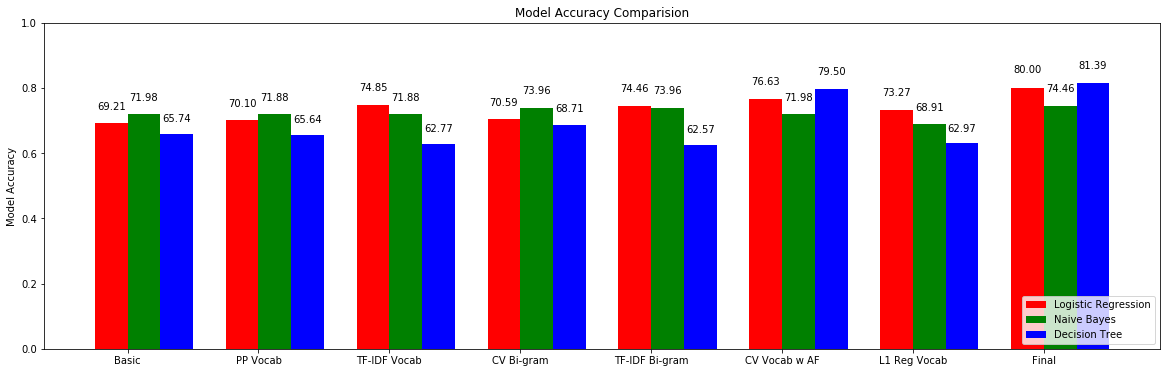

In [22]:
# bar graph of the different accuracies
import matplotlib.pyplot as plt
#plt.rcdefaults()

N = len(accuracy_dict)

# build lists of scores for each model type
nb_accuracy = []
lr_accuracy = []
dt_accuracy = []
x_label_names = []
for i in modification:
    nb_accuracy.append(accuracy_dict[modification[i]]['Naive Bayes'])
    lr_accuracy.append(accuracy_dict[modification[i]]['Logistic Regression'])
    dt_accuracy.append(accuracy_dict[modification[i]]['Decision Tree'])
    x_label_names.append(modification[i])

ind = np.arange(N)  # the x locations for the groups
width = 0.25        # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, lr_accuracy, width, color='r')
rects2 = ax.bar(ind + width, nb_accuracy, width, color='g')
rects3 = ax.bar(ind + width*2, dt_accuracy, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Model Accuracy')
ax.set_title('Model Accuracy Comparision')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(x_label_names)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Logistic Regression', 'Naive Bayes', 'Decision Tree'),
         loc='lower right')

# make the figure larger
fig.set_size_inches(20,6)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        h_text = str("%2.2f" %(height*100))
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                h_text,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# change the y axis limit
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))

plt.show()

In [24]:
df_test

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,t3_i8iy4,Hey all! It's about 95 degrees here and our ki...,[request] pregger gf 95 degree house and no fo...,42.083866,0.000000,57,0,10,0,16,"[AskReddit, COents, Denver, DenverBroncos, Lib...",364,840,j_like,1308963419,1308959819
1,N/A,t3_1mfqi0,I didn't know a place like this exists! \n\nI ...,"[Request] Lost my job day after labour day, st...",223.784537,0.000000,145,0,36,0,29,"[Android, AskReddit, GrandTheftAutoV, IAmA, Mi...",516,1448,0110110101101100,1379263523,1379259923
2,N/A,t3_lclka,Hi Reddit. Im a single dad having a really rou...,(Request) pizza for my kids please?,0.000000,0.000000,0,0,0,0,0,[],0,0,singledad22601,1318636421,1318632821
3,N/A,t3_1jdgdj,Hi I just moved to Waltham MA from my home sta...,[Request] Just moved to a new state(Waltham MA...,481.311273,0.000000,277,0,17,0,30,"[AdviceAnimals, Art, AskReddit, GetMotivated, ...",1058,2062,Neuronut,1375220282,1375216682
4,N/A,t3_t2qt4,We're just sitting here near indianapolis on o...,"[Request] Two girls in between paychecks, we'v...",0.000000,0.000000,0,0,0,0,0,[],0,0,so_damn_hungry,1335934358,1335930758
5,N/A,t3_pvojb,"So, I'm a student in London, and it's my birth...",[REQUEST] It's my birthday tomorrow (UK),144.875093,44.114606,418,2,117,0,41,"[Art, AskReddit, FIFA12, FantasyPL, IAmA, Life...",6331,31919,leiferic,1329601990,1329601990
6,N/A,t3_142n4c,"I'm not entirely sure why, I guess just kindof...","[Request] Just kindof sad/disappointed, could ...",185.766100,0.000000,2,0,2,0,3,"[Random_Acts_Of_Pizza, atheism, technology]",7,27,cafepressguy,1354312678,1354312678
7,N/A,t3_17rja6,I'm a visiting medical student from Costa Rica...,[Request] Visiting student could use warm food.,1198.620231,0.000000,42,0,11,0,14,"[AnimalPorn, AskReddit, Music, Random_Acts_Of_...",176,286,javilopez1,1359831611,1359831611
8,N/A,t3_1lg6u2,My SO and I are moving to the new apartment to...,"[Request] Pregnant, packing @ 2am to move tomo...",43.332118,0.000000,1,0,0,0,1,[IAmA],0,6,RosyGraymalkin,1377933122,1377929522
9,N/A,t3_1b0mtx,My partner is a wonderful gender-queer pansexu...,"[Request] My partner and I hit six-months, we ...",787.698322,0.000000,625,0,129,0,72,"[Anarchism, AnarchistNews, Anarcho_Capitalism,...",2796,5186,vomitisjustskimmilk,1364268605,1364265005
